# Load tfrecords, define model and train

In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
# Dependencies

 # TensorFlow and tf.keras
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)
from tensorflow import keras
from keras import layers
from keras import models

# Helper libraries
import os
import os.path
import glob
import librosa
import librosa.display
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as pd
import pprint

# Check if the GPU is available (otherwise computing will take a looooonnnnggggg time)
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")



Tensorflow Version: 2.12.0
GPU available (YESS!!!!)


In [3]:

# define some values in config
config = {
          'batch_size': 16,
          'shuffle_buffer_size': 300,
          'n_epochs': 10,
          'sr': 44100,
          }



# load tfrecords

### func for decoding tfrecords

In [4]:
# autotune for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

# decode tfrecords
def decode_tf_records(seralized_example):
    feature_description = {
        "voicefixer": tf.io.FixedLenFeature([], tf.string),
        "produced": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(seralized_example, feature_description)

    voicefixer, _ = tf.audio.decode_wav(example["voicefixer"], desired_channels=-1)
    produced, _ = tf.audio.decode_wav(example["produced"], desired_channels=-1)

    # voicefixer, produced = (
    #     tf.squeeze(voicefixer, 1),
    #     tf.squeeze(produced, 1),
    # )
    
    return voicefixer, produced

In [5]:
# load train tfrecords

tfrecords_paths = glob.glob('/content/drive/MyDrive/#Post_processing_net_for_speech_enhancement/Dataset/train_tfrecords/*.tfrecords')
train_dataset = tf.data.TFRecordDataset(tfrecords_paths)
train_dataset = train_dataset.map(decode_tf_records, num_parallel_calls=AUTOTUNE)

# check tensors
for element in train_dataset:
    print(element[0])
    print(element[1])
    break

# # count elements in train_dataset
print(f'Number of elements in train_dataset: {len([d for d in train_dataset])}')

# batching and shuffling
train_dataset = train_dataset.shuffle(config['shuffle_buffer_size']).batch(config['batch_size'])


tf.Tensor(
[[ 0.02279663]
 [ 0.02209473]
 [ 0.0218811 ]
 ...
 [-0.00088501]
 [-0.00109863]
 [-0.00097656]], shape=(441000, 1), dtype=float32)
tf.Tensor(
[[ 0.0680542 ]
 [ 0.06671143]
 [ 0.06832886]
 ...
 [-0.0005188 ]
 [-0.0005188 ]
 [-0.00085449]], shape=(441000, 1), dtype=float32)
Number of elements in train_dataset: 120


In [6]:
# load test tfrecords
tfrecords_paths = glob.glob('/content/drive/MyDrive/#Post_processing_net_for_speech_enhancement/Dataset/test_tfrecords/*.tfrecords')
test_dataset = tf.data.TFRecordDataset(tfrecords_paths)
test_dataset = test_dataset.map(decode_tf_records, num_parallel_calls=AUTOTUNE)

# check tensors
for element in test_dataset:
    print(element[0])
    print(element[1])
    break

# # count elements in test_dataset
print(f'Number of elements in test_dataset: {len([d for d in test_dataset])}')

# batching and shuffling
test_dataset = test_dataset.shuffle(config['shuffle_buffer_size']).batch(config['batch_size'])


tf.Tensor(
[[0.01074219]
 [0.00805664]
 [0.0065918 ]
 ...
 [0.00054932]
 [0.00042725]
 [0.00042725]], shape=(441000, 1), dtype=float32)
tf.Tensor(
[[ 7.7758789e-02]
 [ 2.5817871e-02]
 [-1.6357422e-02]
 ...
 [-2.4414062e-04]
 [-3.0517578e-05]
 [-1.8310547e-04]], shape=(441000, 1), dtype=float32)
Number of elements in test_dataset: 60


In [7]:
# check if datasets are loaded correctly
for d in train_dataset:
    print(d[0].shape)
    print(d[1].shape)
    break   

for d in test_dataset:
    print(d[0].shape)
    print(d[1].shape)
    break

(16, 441000, 1)
(16, 441000, 1)
(16, 441000, 1)
(16, 441000, 1)


# look at data

<ipython-input-8-89bbcadaac2e>:23: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(np.squeeze(wave), x_axis='time', sr=config['sr'], ax=ax[k][j], label='test_file')
<ipython-input-8-89bbcadaac2e>:24: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(np.squeeze(ground_truth), alpha=0.3, x_axis='time', sr=config['sr'], ax=ax[k][j], label='ground_truth')


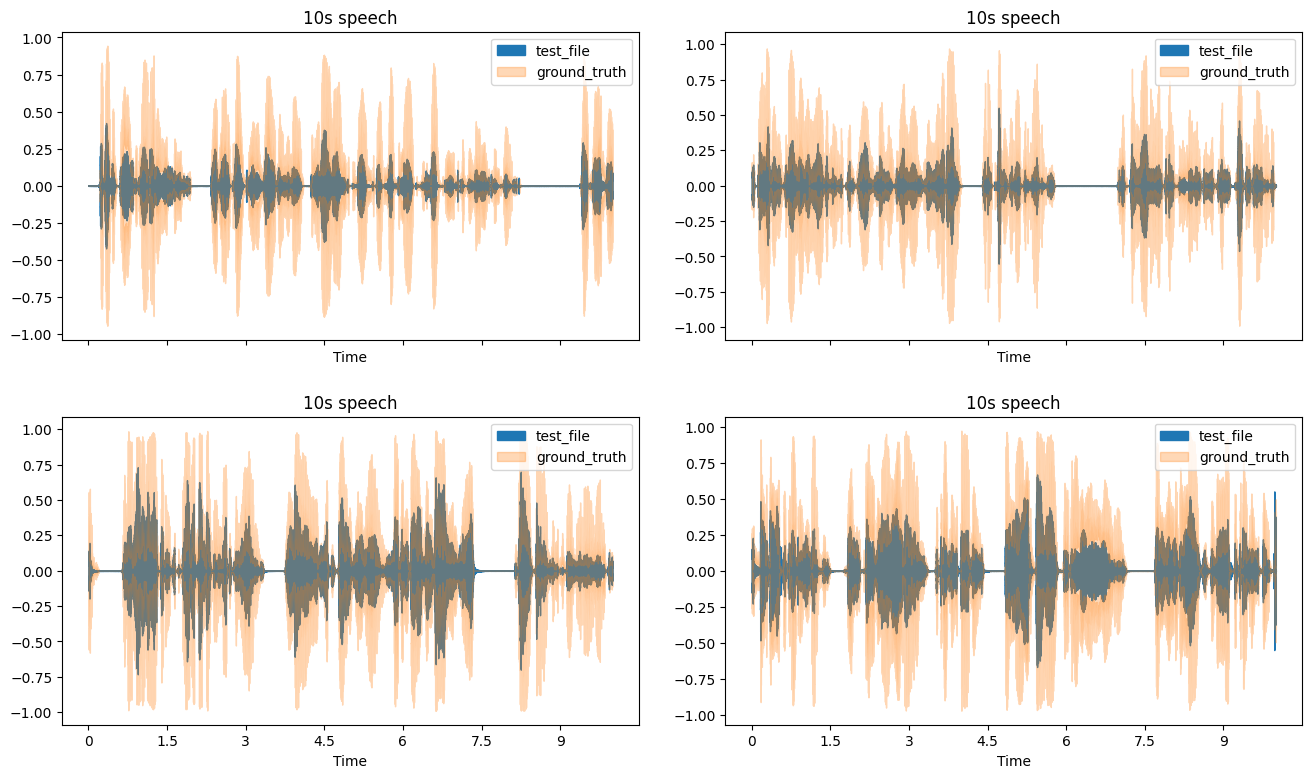

----------- 1. speechsnippet ---------------

Voicefixer file


corresponding produced file



----------- 2. speechsnippet ---------------

Voicefixer file


corresponding produced file



----------- 3. speechsnippet ---------------

Voicefixer file


corresponding produced file



----------- 4. speechsnippet ---------------

Voicefixer file


corresponding produced file


In [8]:
# look at some example data from train dataset
wavs = train_dataset.unbatch().as_numpy_iterator()
noisy = []
gt = []

# Setup Subplot
nrows, ncols = 2, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(16, 9))


# iterate over dataset
for i, sample in enumerate(wavs):
    
    # get the column and row by modulo and remainder
    j = i % ncols
    k = int(i / ncols)
    
    # extract noisy and produced speech file from tensors
    wave = sample[0]
    ground_truth = sample[1]
        
    # plot files
    librosa.display.waveshow(np.squeeze(wave), x_axis='time', sr=config['sr'], ax=ax[k][j], label='test_file')
    librosa.display.waveshow(np.squeeze(ground_truth), alpha=0.3, x_axis='time', sr=config['sr'], ax=ax[k][j], label='ground_truth')
    ax[k][j].legend()
    ax[k][j].axis('on')
    ax[k][j].set_title('10s speech')  

    # save speech to arrays
    noisy.append(np.squeeze(wave))
    gt.append(np.squeeze(ground_truth))
    
    if i+1 == ncols*nrows:
        break
    
# adjust whitespace in between subplots        
plt.subplots_adjust(hspace=0.25, wspace=0.15)
plt.show()


# listen to the audio samples
for i in range(len(gt)):
    print(f'----------- {i+1}. speechsnippet ---------------')
    print('')
    print(f'Voicefixer file')
    pd.display(pd.Audio(noisy[i].T, rate=config['sr']))
    print(f'corresponding produced file')
    pd.display(pd.Audio(gt[i].T, rate=config['sr']))
    print('')

## Model architecture

In [9]:
input_shape = (441000, 1)
output_channels = 1

filter_size = 8
kernel_size = 2

# build model with 12 layers
def build_model(input_shape):

    # define model
    model = keras.Sequential(name='PostNet_Conv1D')
    model.add(keras.Input(shape=input_shape))

    # add layer 
    model.add(keras.layers.Conv1D(filters=filter_size, kernel_size=kernel_size, padding='same'))
    model.add(keras.layers.Activation('tanh'))

    # Add the remaining Conv1D layers
    for _ in range(11):
        model.add(keras.layers.Conv1D(filters=filter_size, kernel_size=kernel_size, padding='same'))
        model.add(keras.layers.Activation('tanh'))

    # Add the final Conv1D layer
    model.add(keras.layers.Conv1D(filters=output_channels, kernel_size=1, padding='same'))
    model.add(keras.layers.Activation('tanh'))

    return model

In [10]:
# get model
model = build_model(input_shape = input_shape)


# define metrics to monitor mse
metrics = [tf.keras.losses.MeanSquaredError()]

# Set up optimizer with high initial learning rate
opt = keras.optimizers.Adam(learning_rate=0.06)


# # custom callback to log wav files
# def logging_wav(epoch, logs={}):
#     ...


# define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/#Post_processing_net_for_speech_enhancement/model_checkpoint',
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    # keras.callbacks.EarlyStopping(
    #     monitor='val_loss',
    #     patience=5,
    #     verbose=1),
    # keras.callbacks.LambdaCallback(
    #     on_epoch_end = logging_wav),
    keras.callbacks.TensorBoard(
        log_dir='/content/drive/MyDrive/#Post_processing_net_for_speech_enhancement/logs',
        histogram_freq=1,
        write_graph=True,
        write_images=True,
        update_freq='epoch',
        profile_batch=2,
        embeddings_freq=1)
]   

# compile model
model.compile(optimizer=opt,
              loss=tf.keras.losses.MeanAbsolutePercentageError(),
              metrics=metrics)

model.summary()

Model: "PostNet_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 441000, 8)         24        
                                                                 
 activation (Activation)     (None, 441000, 8)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 441000, 8)         136       
                                                                 
 activation_1 (Activation)   (None, 441000, 8)         0         
                                                                 
 conv1d_2 (Conv1D)           (None, 441000, 8)         136       
                                                                 
 activation_2 (Activation)   (None, 441000, 8)         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 441000, 8)      

In [11]:
# fit model
history = model.fit(train_dataset,
                    epochs=config['n_epochs'],
                    validation_data=test_dataset,
                    callbacks=callbacks)

# save model
model.save('/content/drive/MyDrive/#Post_processing_net_for_speech_enhancement/model.h5')

# save history
with open('/content/drive/MyDrive/#Post_processing_net_for_speech_enhancement/history.json', 'w+') as fp:
    json.dump(history.history, fp, sort_keys=True, indent=4)



Epoch 1/10
      8/Unknown - 25s 680ms/step - loss: 2323735.5000 - mean_squared_error: 0.1124
Epoch 1: val_loss improved from inf to 3358571.75000, saving model to ./model_checkpoint


8/8 [==============================] - 32s 2s/step - loss: 2323735.5000 - mean_squared_error: 0.1124 - val_loss: 3358571.7500 - val_mean_squared_error: 0.1052
Epoch 2/10
8/8 [==============================] - ETA: 0s - loss: 1740741.5000 - mean_squared_error: 0.0560
Epoch 2: val_loss improved from 3358571.75000 to 412875.00000, saving model to ./model_checkpoint


8/8 [==============================] - 13s 1s/step - loss: 1740741.5000 - mean_squared_error: 0.0560 - val_loss: 412875.0000 - val_mean_squared_error: 0.0136
Epoch 3/10
8/8 [==============================] - ETA: 0s - loss: 1235113.2500 - mean_squared_error: 0.0468
Epoch 3: val_loss did not improve from 412875.00000
8/8 [==============================] - 10s 994ms/step - loss: 1235113.2500 - mean_squared_error: 0.0468 - val_loss: 2599374.5000 - val_mean_squared_error: 0.0679
Epoch 4/10
8/8 [==============================] - ETA: 0s - loss: 1028703.4375 - mean_squared_error: 0.0373
Epoch 4: val_loss improved from 412875.00000 to 363057.96875, saving model to ./model_checkpoint


8/8 [==============================] - 14s 1s/step - loss: 1028703.4375 - mean_squared_error: 0.0373 - val_loss: 363057.9688 - val_mean_squared_error: 0.0133
Epoch 5/10
8/8 [==============================] - ETA: 0s - loss: 556053.3125 - mean_squared_error: 0.0258
Epoch 5: val_loss did not improve from 363057.96875
8/8 [==============================] - 11s 984ms/step - loss: 556053.3125 - mean_squared_error: 0.0258 - val_loss: 872773.3750 - val_mean_squared_error: 0.0184
Epoch 6/10
8/8 [==============================] - ETA: 0s - loss: 657885.1250 - mean_squared_error: 0.0268
Epoch 6: val_loss improved from 363057.96875 to 185393.50000, saving model to ./model_checkpoint


8/8 [==============================] - 14s 1s/step - loss: 657885.1250 - mean_squared_error: 0.0268 - val_loss: 185393.5000 - val_mean_squared_error: 0.0124
Epoch 7/10
8/8 [==============================] - ETA: 0s - loss: 254092.4844 - mean_squared_error: 0.0232
Epoch 7: val_loss did not improve from 185393.50000
8/8 [==============================] - 13s 1s/step - loss: 254092.4844 - mean_squared_error: 0.0232 - val_loss: 828628.6875 - val_mean_squared_error: 0.0178
Epoch 8/10
8/8 [==============================] - ETA: 0s - loss: 522580.8750 - mean_squared_error: 0.0246
Epoch 8: val_loss improved from 185393.50000 to 107714.16406, saving model to ./model_checkpoint


8/8 [==============================] - 14s 1s/step - loss: 522580.8750 - mean_squared_error: 0.0246 - val_loss: 107714.1641 - val_mean_squared_error: 0.0123
Epoch 9/10
8/8 [==============================] - ETA: 0s - loss: 162752.2500 - mean_squared_error: 0.0216
Epoch 9: val_loss did not improve from 107714.16406
8/8 [==============================] - 11s 990ms/step - loss: 162752.2500 - mean_squared_error: 0.0216 - val_loss: 489102.9688 - val_mean_squared_error: 0.0141
Epoch 10/10
8/8 [==============================] - ETA: 0s - loss: 417361.8750 - mean_squared_error: 0.0233
Epoch 10: val_loss did not improve from 107714.16406
8/8 [==============================] - 11s 1s/step - loss: 417361.8750 - mean_squared_error: 0.0233 - val_loss: 316678.6562 - val_mean_squared_error: 0.0130


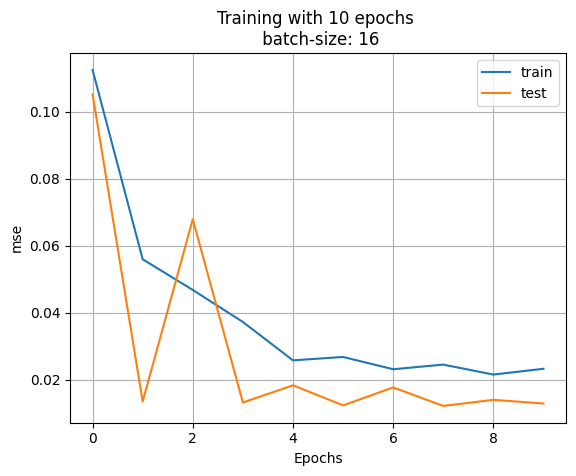

In [12]:
# plot mse
train_mse = history.history['mean_squared_error']
eval_mse = history.history['val_mean_squared_error']

fig2 = plt.figure()
plt.plot(range(config['n_epochs']), train_mse, label='train')
plt.plot(range(config['n_epochs']), eval_mse, label='test')
plt.legend()
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('mse')
plt.title('Training with ' 
                           + str(config['n_epochs'])
                           + ' epochs \n batch-size: '
                           + str(config['batch_size']))
                     
plt.show()  